In [1]:
%pylab inline
import pandas as pd
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoIAFNormal
from brmp import defm
from brmp.fit import summary
from brmp.pyro_backend import backend as pyro_backend
from brmp.numpyro_backend import backend as numpyro

Populating the interactive namespace from numpy and matplotlib


## Introduction

This notebook demonstrates the use of interactions in model specifications by recreating some of the models, inferences and plots found in the following:

* https://bookdown.org/content/1850/interactions.html
* http://pyro.ai/examples/bayesian_regression.html

## Data

In [2]:
df = pd.read_csv('rugged_data.csv', encoding="ISO-8859-1")
df = df[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df['cont_africa'] = pd.Categorical(df['cont_africa'])
df["log_gdp"] = np.log(df["rgdppc_2000"])
del df['rgdppc_2000']

In [3]:
df.head()

,cont_africa,rugged,log_gdp
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


## Model

In [4]:
# eqv. to `1 + rugged*cont_africa` (the * operator is not yet supported)
model = defm('log_gdp ~ 1 + rugged + cont_africa + rugged:cont_africa', df)
model

Population
----------------------------------------
Coef Priors:
intercept       | Cauchy(loc=0.0, scale=1.0)
cont_africa[1]  | Cauchy(loc=0.0, scale=1.0)
rugged          | Cauchy(loc=0.0, scale=1.0)
rugged:cont_africa[1] | Cauchy(loc=0.0, scale=1.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfCauchy(scale=3.0)

Here's the design matrix generated by the system for this model/data pair. The columns correspond to the population coefficients mentioned in the model description shown above.

In [5]:
model.data['X'][0:5]

array([[1.   , 1.   , 0.858, 0.858],
       [1.   , 0.   , 3.427, 0.   ],
       [1.   , 0.   , 0.769, 0.   ],
       [1.   , 0.   , 0.775, 0.   ],
       [1.   , 0.   , 2.688, 0.   ]])

## Inference

In [6]:
fit = model.fit(iter=1000, backend=numpyro)
# Or using e.g. Pyro/SVI:
#fit = model.fit(algo='svi',
#                iter=2500,
#                num_samples=1000,
#                autoguide=AutoIAFNormal,
#                optim=Adam({'lr': 0.03}))

sample: 100%|██████████| 1000/1000 [00:01<00:00, 738.47it/s, 7 steps of size 3.67e-01. acc. prob=0.87]


In [7]:
fit.marginals()

                         mean    sd  2.5%   25%   50%   75% 97.5%
            b_intercept  9.19  0.14  8.93  9.10  9.19  9.28  9.46
       b_cont_africa[1] -1.88  0.23 -2.32 -2.03 -1.88 -1.73 -1.45
               b_rugged -0.19  0.08 -0.33 -0.24 -0.19 -0.14 -0.04
b_rugged:cont_africa[1]  0.36  0.12  0.12  0.28  0.36  0.45  0.61
                  sigma  0.95  0.05  0.85  0.91  0.94  0.98  1.05

## Model Evaluation

We start by generating a new set of predictors on which to evaluate the model. This is comprised of a series of equally spaced values for ruggedness running from 0 to 6.2 (inclusive). This is repeated for both `cont_africa=0` and `cont_africa=1`.

In [8]:
def make_new_data(*args):
    rnge = np.arange(*args)
    zeros = np.zeros(len(rnge), dtype=np.int64)
    ones = np.ones(len(rnge), dtype=np.int64)
    return pd.DataFrame(dict(
        rugged=np.hstack((rnge, rnge)),
        cont_africa=pd.Categorical(np.hstack((zeros, ones)))
    ))
nd = make_new_data(0., 6.3, 0.1)
nd.head()

,rugged,cont_africa
0,0.0,0
1,0.1,0
2,0.2,0
3,0.3,0
4,0.4,0


We can use the `fitted` method to compute the posterior distribution over the expected response for each data point in our new data set.

(`summary(fit.fitted(data=...))` is analogous to `fitted(fit, newdata=..., summary=TRUE)` in brms.)

In [9]:
smry = summary(fit.fitted(data=nd))
assert len(nd) == smry.array.shape[0] # there is one row in the summary for each row of the new data set
smry # TODO: It would be good to be able to index this (directly, not via `array`) while retaining the __repr__

 mean    sd  2.5%   25%   50%   75% 97.5%
 9.19  0.14  8.93  9.10  9.19  9.28  9.46
 9.17  0.13  8.92  9.08  9.17  9.25  9.43
 9.15  0.12  8.91  9.07  9.16  9.23  9.40
 9.13  0.12  8.90  9.05  9.14  9.21  9.37
 9.12  0.11  8.89  9.04  9.12  9.19  9.34
 9.10  0.11  8.88  9.03  9.10  9.17  9.31
 9.08  0.10  8.87  9.01  9.08  9.15  9.28
 9.06  0.10  8.86  9.00  9.06  9.12  9.25
 9.04  0.10  8.85  8.98  9.04  9.10  9.23
 9.02  0.09  8.84  8.96  9.02  9.08  9.20
 9.00  0.09  8.82  8.95  9.00  9.06  9.18
 8.98  0.09  8.81  8.93  8.99  9.04  9.15
 8.97  0.09  8.79  8.91  8.97  9.02  9.13
 8.95  0.09  8.77  8.89  8.95  9.00  9.11
 8.93  0.09  8.75  8.87  8.93  8.99  9.09
 8.91  0.09  8.73  8.85  8.91  8.97  9.07
 8.89  0.09  8.71  8.84  8.89  8.95  9.06
 8.87  0.09  8.69  8.81  8.87  8.93  9.04
 8.85  0.09  8.67  8.79  8.86  8.91  9.02
 8.84  0.09  8.64  8.77  8.84  8.90  9.01
 8.82  0.10  8.62  8.75  8.82  8.88  9.00
 8.80  0.10  8.59  8.73  8.80  8.87  8.99
 8.78  0.10  8.57  8.71  8.78  8.8

With this information in hand we are able to recreate the regression line plot.

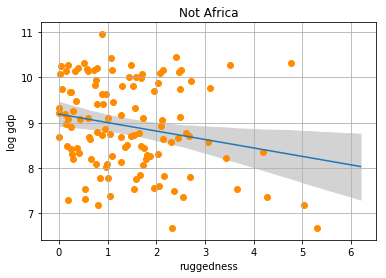

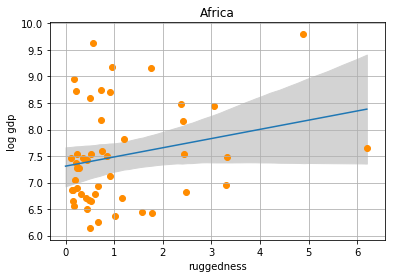

In [10]:
def plot_fitted_summary(nd, smry, cont_africa):
    assert cont_africa in [0, 1]
    # Select either African/other rows from original data, new data and summary.
    data = df[df.cont_africa == cont_africa]      # Original data
    newdata = nd[nd.cont_africa == cont_africa]   # Data used for summary
    s = smry.array[nd.cont_africa == cont_africa] # Summary
    figure()
    title('Africa' if cont_africa == 1 else 'Not Africa')
    xlabel('ruggedness')
    ylabel('log gdp')
    grid()
    # Pick out appropriate columns from the summary table shown above.
    mean =  s[:, 0] # mean
    lower = s[:, 2] # 2.5%
    upper = s[:, 6] # 97.5%
    fill_between(newdata['rugged'], lower, upper, color='lightgray')
    plot(newdata['rugged'], mean)
    scatter(data['rugged'], data['log_gdp'], c='darkorange')

plot_fitted_summary(nd, smry, 0)
plot_fitted_summary(nd, smry, 1)

The posterior predictive plot can be obtained by passing the `what='sample'` argument to `fitted`. This causes `fitted` to generate samples from the response distribution rather than return the expected response.

(This is analogous to the `predict(...)` method in brms.)

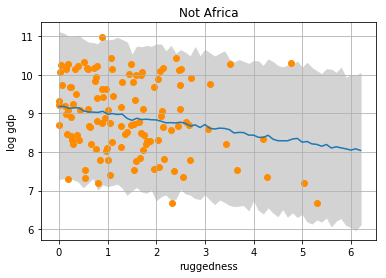

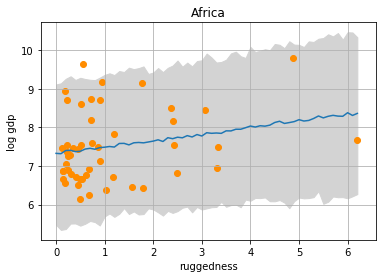

In [11]:
smry2 = summary(fit.fitted(what='sample', data=nd))
#smry2
plot_fitted_summary(nd, smry2, 0)
plot_fitted_summary(nd, smry2, 1)

Here's a similar plot using a wider range of values for `ruggedness`.

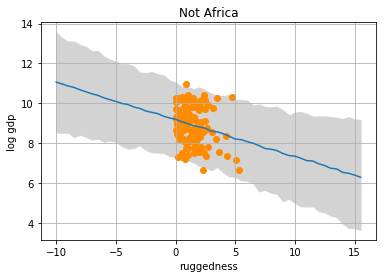

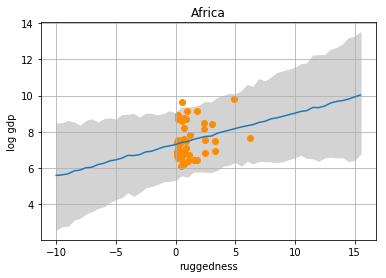

In [12]:
nd2 = make_new_data(-10., 16., 0.5)
smry3 = summary(fit.fitted(what='sample', data=nd2))
plot_fitted_summary(nd2, smry3, 0)
plot_fitted_summary(nd2, smry3, 1)

### Slope

For African countries (rows in which `cont_africa=1`) the slope of the regression line is given by `rugged + rugged:cont_africa[1]`. For other countries the slope is simply `rugged`. Here we extract these values from the posterior samples using the `get_scalar_param` method. (This acccepts as input those parameter names that appear in the output of `fit.marginals()` above, and returns a vector with length equal to the number of samples collected during inference.)

In [13]:
rugged = fit.get_scalar_param('b_rugged')
rugged_cont_africa = fit.get_scalar_param('b_rugged:cont_africa[1]')
gamma_africa = rugged + rugged_cont_africa
gamma_not_africa = rugged

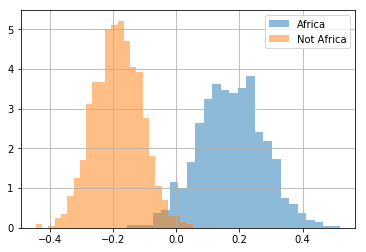

In [14]:
hist(gamma_africa, bins=25, alpha=0.5, density=True, label='Africa');
hist(gamma_not_africa, bins=25, alpha=0.5, density=True, label='Not Africa');
grid()
legend();